In [0]:
from typing import Tuple
import torch 
def sgd_factorise_ad(A:torch.Tensor,rank:int,num_epochs=2000,lr=0.01):
  U = torch.rand(A.shape[0],rank,requires_grad=True)
  V = torch.rand(A.shape[1],rank,requires_grad=True)

  for epoch in range(num_epochs):
    U.grad = None
    V.grad = None
    error = ((A - (U@V.t()))**2)
    #z = error.mean()
    #z.backward()
    error.backward(torch.ones(A.shape[0],A.shape[1]))
    U.data = U - lr*U.grad
    V.data = V - lr*V.grad
  return U,V



In [15]:
#A = torch.rand(8,7,requires_grad=True)
A = torch.Tensor([[0.3374,0.6005,0.1735],
[3.3359,0.0492,1.8374],
[2.9407,0.5301,2.2620]])
rank = 2
B,C = sgd_factorise_ad(A,rank)

def reconstruct_loss(B:torch.Tensor,C:torch.tensor,A:torch.Tensor):
  loss = torch.nn.functional.mse_loss(B@C.t(),A,reduction='sum')
  return loss
loss = reconstruct_loss(B,C,A)
print(loss)


tensor(0.1219, grad_fn=<MseLossBackward>)


In [16]:
# encoding=utf8
# from sklearn.datasets import load_iris

# irix = load_iris()
# data = torch.tensor(irix.data,dtype=torch.float32)

import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'+'/iris/iris.data',header=None,encoding='utf-8')
data = torch.tensor(df.iloc[:,[0,1,2,3]].values)
data = data -data.mean(dim=0)
D,E = sgd_factorise_ad(data,2)
ls_real = torch.nn.functional.mse_loss(D@E.t(),data,reduction='sum')
print(ls_real)

tensor(15.2288, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [17]:
u, s, v = torch.svd(data)
print(s.shape)
#print(s)
s[len(s)-1]=0
diag_s = torch.empty((u.shape[1],u.shape[1]),dtype=float)
torch.nn.init.zeros_(diag_s)
for i in range(len(s)):
  diag_s[i][i]=s[i]

recon = u@diag_s@v.t()

print(torch.nn.functional.mse_loss(recon,data,reduction='sum'))

torch.Size([4])
tensor(3.5288, dtype=torch.float64)


torch.Size([150, 4])


Text(0.5, 1.0, 'U hat')

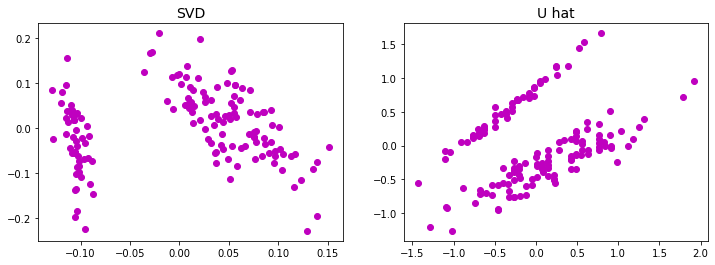

In [19]:
print(u.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
ax[0].scatter(u[:,0].detach().numpy(),u[:,1].detach().numpy(),c='m')
ax[0].set_title("SVD", fontsize=14)
ax[1].scatter(D[:,0].detach().numpy(),D[:,1].detach().numpy(),c='m')
ax[1].set_title("U hat", fontsize=14)


In [26]:
#MLP
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'+'/iris/iris.data',header=None,encoding='utf-8')
df=df.sample(frac=1)

#label
mapping = {k:v for v,k in enumerate(df[4].unique())}
df[5]=df[4].map(mapping)

#normalize
alldata = torch.tensor(df.iloc[:,[0,1,2,3]].values,dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

# c r e a t e d a t a s e t s
targetstr=torch.tensor(df.iloc[:100,5].values,dtype=torch.long)
targetsva=torch.tensor(df.iloc[100:,5].values,dtype=torch.long)
data_tr = alldata[:100]
data_va = alldata[100:]

def mlp(data,target,valid,validtarget):
  epoh = 100
  lr =0.01
  W1=torch.rand((4,12),dtype=torch.float,requires_grad=True)
  W2=torch.rand((12,3),dtype=torch.float,requires_grad=True)
  b1=torch.zeros((1,12),dtype=torch.float,requires_grad=True)
  b2=torch.zeros((1,3),dtype=torch.float,requires_grad=True)
 
  for item in range(epoh):
    W1.grad= None
    W2.grad= None
    b1.grad= None
    b2.grad= None          
    logits=torch.relu(data @ W1 + b1)@W2 + b2
    J = (torch.nn.functional.cross_entropy(logits, target))
    J.backward()
    W1.data = W1 - lr*W1.grad
    W2.data = W2 - lr*W2.grad
    b1.data = b1 - lr*b1.grad
    b2.data = b2 - lr*b2.grad
  print("Train:",J)
  print("Valid:",torch.nn.functional.cross_entropy(torch.relu(valid @ W1 + b1)@W2 + b2, validtarget))

mlp(data_tr,targetstr,data_va,targetsva)


Train: tensor(0.7495, grad_fn=<NllLossBackward>)
Valid: tensor(0.7241, grad_fn=<NllLossBackward>)
